# Imports and API

In [70]:
import sys
import os
from typing import Any

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product
import wandb

sys.path.append("../../")

from datasets.simulated.data_generators import (
    LookupTableDataGenerator,
    SyntacticDataGenerator,
)

# Style for making nice-looking paper plots with page-scale figure size units
sns.set_theme(
    style="ticks",
    context="paper",
    palette="deep",
    rc={
        "font.size": 5,
        "axes.titlesize": 6,
        "axes.labelsize": 6,
        "axes.labelpad": 2,
        "xtick.labelsize": 4.5,
        "ytick.labelsize": 4.5,
        "legend.title_fontsize": 4.5,
        "legend.fontsize": 4.5,
        "legend.markerscale": 0.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.4,
        "xtick.major.width": 0.4,
        "ytick.major.width": 0.4,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,
        "xtick.minor.width": 0.2,
        "ytick.minor.width": 0.2,
        "figure.constrained_layout.use": True,
        "figure.dpi": 200,
    },
)


def topological_similarity(w, z):
    w = F.one_hot(torch.from_numpy(w)).float().numpy().reshape(w.shape[0], -1)
    z_rdm = pdist(z, metric="euclidean")
    w_rdm = pdist(w, metric="cityblock")
    topsim = pearsonr(z_rdm, w_rdm).statistic
    return topsim


# Weights & Biases

api = wandb.Api()


def get_run_results(
    entity: str,
    project: str,
    metrics: list[str],
    filters: dict[str, Any],
    x_axis: str = "epoch",
    save_path: str = None,
) -> pd.DataFrame:
    """Pulls data from the W&B API and returns a dataframe with either the best epoch performance for each run
    (when `best_epoch=True`) or the entire training trajectory across runs (when `best_epoch=False`).

    Args:
        entity (str): W&B entity.
        dataset (str): The W&B project.
        metrics (list[str]): Logged metrics we want to keep.
        filters (dict[str, Any]): W&B API filters used to select only a subset of runs. See code below for examples.
        x_axis (str): The x-axis to plot the metrics against.
        save_path (str, optional): Optionally save the resulting dataframe. Note that if the file already exists, we retrieve its data and return that rather than querying the API. Defaults to `None`.

    Returns:
        pd.DataFrame: Dataframe of results. It contains the run id, epoch, config arguments, and `metrics`.
    """
    # If data has already been downloaded, don't make another API call
    if os.path.exists(save_path):
        print(f"Loading from cached file {save_path}...")
        data = pd.read_csv(save_path)
        return data

    # Fetch all run data from the API
    runs = api.runs(f"{entity}/{project}", filters=filters)

    # Collect all of the run histories into a dataframe
    data = []
    for run in runs:
        run_data = run.history(samples=1000000, x_axis=x_axis, keys=metrics)
        # run_data = run.history(samples=1000000, x_axis="epoch", keys=metrics)
        run_data = run_data.assign(run_id=run.id, **run.config)
        data.append(run_data)
    data = pd.concat(data)

    # Re-order columns
    data = data[["run_id", x_axis] + metrics + list(run.config.keys())]

    # Cache data
    if save_path is not None:
        data.to_csv(save_path, index=False)

    return data

# Simulations

## Lookup table

In [3]:
num_words = 16
vocab_size = 10
z_dim = 64
noise_ratio = 0.01
n_samples = 1000
n_seeds = 10
per_sample = True

### Varying the sentence length

In [9]:
if os.path.exists("data/lookup_table_sentence_length.csv"):
    print("Loading data from cache")
    data_sentence_length = pd.read_csv("data/lookup_table_sentence_length.csv")
else:
    data_sentence_length = []
    for k in tqdm(range(1, z_dim + 1)):
        for i in enumerate(range(n_seeds)):
            if z_dim % k != 0:
                continue
            data_gen = LookupTableDataGenerator(
                num_words=k,
                vocab_size=vocab_size,
                z_dim=z_dim,
                disentanglement=1,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_sentence_length.append(
                {
                    "Sentence length": k,
                    "Vocabulary size": vocab_size,
                    "Representation dimensionality": z_dim,
                    "Disentanglement": 1,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_sentence_length = pd.DataFrame(data_sentence_length)
    data_sentence_length.to_csv("data/lookup_table_sentence_length.csv", index=False)

Loading data from cache


### Varying vocabulary size

In [11]:
if os.path.exists("data/lookup_table_vocab_size.csv"):
    print("Loading data from cache")
    data_vocab_size = pd.read_csv("data/lookup_table_vocab_size.csv")
else:
    data_vocab_size = []
    for v in tqdm(range(2, 100 + 1)):
        for i in enumerate(range(n_seeds)):
            data_gen = LookupTableDataGenerator(
                num_words=num_words,
                vocab_size=v,
                z_dim=z_dim,
                disentanglement=1,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_vocab_size.append(
                {
                    "Sentence length": num_words,
                    "Vocabulary size": v,
                    "Representation dimensionality": z_dim,
                    "Disentanglement": 1,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_vocab_size = pd.DataFrame(data_vocab_size)
    data_vocab_size.to_csv("data/lookup_table_vocab_size.csv", index=False)

100%|██████████| 99/99 [05:33<00:00,  3.37s/it]


### Varying $dim(z)$

In [12]:
if os.path.exists("data/lookup_table_zdim.csv"):
    print("Loading data from cache")
    data_zdim = pd.read_csv("data/lookup_table_zdim.csv")
else:
    data_zdim = []
    for d in tqdm(range(num_words, num_words * 10 + 1)):
        for i in enumerate(range(n_seeds)):
            if d % num_words != 0:
                continue
            data_gen = LookupTableDataGenerator(
                num_words=num_words,
                vocab_size=vocab_size,
                z_dim=d,
                disentanglement=1,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_zdim.append(
                {
                    "Sentence length": num_words,
                    "Vocabulary size": vocab_size,
                    "Representation dimensionality": d,
                    "Disentanglement": 1,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_zdim = pd.DataFrame(data_zdim)
    data_zdim.to_csv("data/lookup_table_zdim.csv", index=False)

100%|██████████| 145/145 [00:20<00:00,  7.24it/s]


### Varying disentanglement

In [13]:
if os.path.exists("data/lookup_table_disentanglement.csv"):
    print("Loading data from cache")
    data_disentanglement = pd.read_csv("data/lookup_table_disentanglement.csv")
else:
    data_disentanglement = []
    for d in tqdm(range(1, num_words + 1)):
        for i in enumerate(range(n_seeds)):
            if num_words % d != 0:
                continue
            data_gen = LookupTableDataGenerator(
                num_words=num_words,
                vocab_size=2,
                z_dim=z_dim,
                disentanglement=d,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_disentanglement.append(
                {
                    "Sentence length": num_words,
                    "Vocabulary size": vocab_size,
                    "Representation dimensionality": z_dim,
                    "Disentanglement": d,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_disentanglement = pd.DataFrame(data_disentanglement)
    data_disentanglement.to_csv("data/lookup_table_disentanglement.csv", index=False)

100%|██████████| 16/16 [01:40<00:00,  6.27s/it]


### Plot

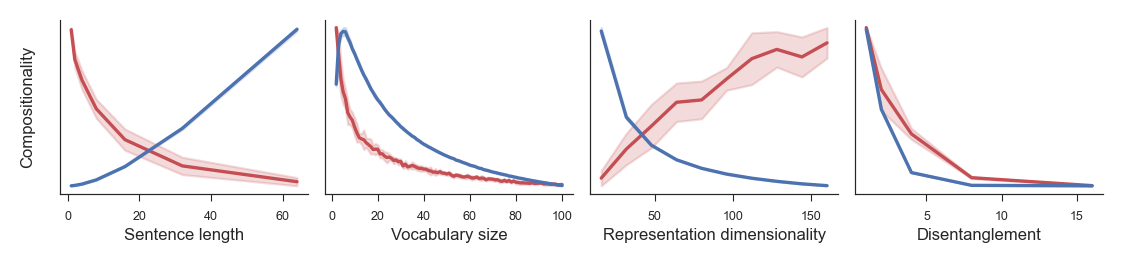

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(5.5, 1.2))

experiments = {
    "Sentence length": data_sentence_length,
    "Vocabulary size": data_vocab_size,
    "Representation dimensionality": data_zdim,
    "Disentanglement": data_disentanglement,
}

for i, variable in enumerate(experiments):
    ax1, ax2 = axs[i], axs[i].twinx()
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Topological similarity",
        errorbar="sd",
        color=sns.color_palette()[3],
        ax=ax1,
    )
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Compositionality",
        errorbar="sd",
        color=sns.color_palette()[0],
        ax=ax2,
    )
    ax1.set(ylabel=None)
    ax2.set(ylabel=None)
    ax1.tick_params(axis="y", left=False, labelleft=False)
    ax2.tick_params(axis="y", right=False, labelright=False)

axs[0].set(ylabel="Compositionality")
axs[0].yaxis.set_label_coords(-0.1, 0.5)

fig.savefig("saved/lookup_table.pdf")
plt.show()

## Grammar

In [3]:
z_dim = 10
num_words = 16
vocab_size = 100
num_terminal_pos = 5
noise_ratio = 0.01
n_samples = 1000
n_seeds = 10
per_sample = True

vocab_terms = {i: "T_" + str(i % num_terminal_pos + 1) for i in range(vocab_size)}
language = {
    f"T_{i + 1}": [
        f"T_{(i + 1) % (num_terminal_pos) + 1}",
        f"T_{(i + 2) % (num_terminal_pos) + 1}",
    ]
    for i in range(num_terminal_pos)
}
language.update({"START": [f"T_1", f"T_2"]})

grammar_width = 3
grammar_depth = 2


def gen_grammar(pos_levels: list[int]):
    grammar = {}
    prev_pos_transitions = [
        (ti, tj) for ti in language for tj in language[ti] if ti != "START"
    ]

    for level, num_next_pos in enumerate(pos_levels):
        rules = {}
        for i, trans in enumerate(prev_pos_transitions):
            rules[trans] = f"r{level}_{i % num_next_pos + 1}"
        prev_pos_transitions = product(range(1, num_next_pos + 1), repeat=2)
        prev_pos_transitions = [
            (f"r{level}_{i}", f"r{level}_{j}") for i, j in prev_pos_transitions
        ]
        grammar.update(rules)
    grammar.update(
        {
            trans: f"r{level}_{i % num_next_pos + 1}"
            for i, trans in enumerate(prev_pos_transitions)
        }
    )
    roots = [f"r{level}_{i}" for i in range(1, num_next_pos + 1)]
    return grammar, roots

### Varying width (same hierarchical depth, different numbers of rules)

In [43]:
if os.path.exists("data/grammar_width.csv"):
    print("Loading data from cache")
    data_grammar_width = pd.read_csv("data/grammar_width.csv")
else:
    data_grammar_width = []
    for wid in tqdm(range(1, 5)):
        for i in enumerate(range(n_seeds)):
            grammar, roots = gen_grammar([wid] * grammar_depth)
            data_gen = SyntacticDataGenerator(
                z_dim=z_dim,
                num_words=num_words,
                vocab_size=vocab_size,
                vocab_terms=vocab_terms,
                grammar=grammar,
                roots=roots,
                language=language,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_grammar_width.append(
                {
                    "Representation dimensionality": z_dim,
                    "Sentence length": num_words,
                    "Vocabulary size": vocab_size,
                    "Number of rules": len(grammar),
                    "Grammar width": wid,
                    "Grammar depth": grammar_depth,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_grammar_width = pd.DataFrame(data_grammar_width)
    data_grammar_width.to_csv("data/grammar_width.csv", index=False)

100%|██████████| 4/4 [04:01<00:00, 60.41s/it]


### Varying depth (hierarchical vs. recursive)

In [44]:
if os.path.exists("data/grammar_depth.csv"):
    print("Loading data from cache")
    data_grammar_depth = pd.read_csv("data/grammar_depth.csv")
else:
    data_grammar_depth = []
    for d in tqdm(range(1, 5)):
        for i in enumerate(range(n_seeds)):
            grammar, roots = gen_grammar([grammar_width] * d)
            data_gen = SyntacticDataGenerator(
                z_dim=z_dim,
                num_words=num_words,
                vocab_size=vocab_size,
                vocab_terms=vocab_terms,
                grammar=grammar,
                roots=roots,
                language=language,
                noise_ratio=noise_ratio,
                random_seed=i,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_grammar_depth.append(
                {
                    "Representation dimensionality": z_dim,
                    "Sentence length": num_words,
                    "Vocabulary size": vocab_size,
                    "Number of rules": len(grammar),
                    "Grammar width": grammar_width,
                    "Grammar depth": d,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                }
            )
    data_grammar_depth = pd.DataFrame(data_grammar_depth)
    data_grammar_depth.to_csv("data/grammar_depth.csv", index=False)

100%|██████████| 4/4 [04:42<00:00, 70.65s/it] 


### Plots

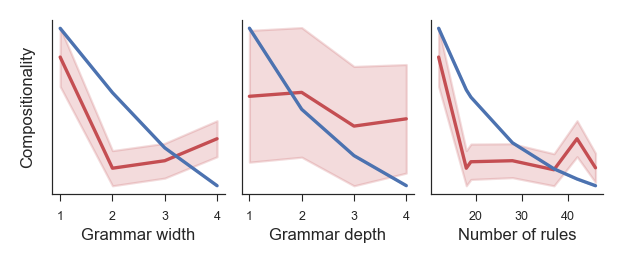

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(3, 1.2))

experiments = {
    "Grammar width": data_grammar_width,
    "Grammar depth": data_grammar_depth,
    "Number of rules": pd.concat([data_grammar_width, data_grammar_depth]),
}

for i, variable in enumerate(experiments):
    ax1, ax2 = axs[i], axs[i].twinx()
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Topological similarity",
        errorbar="sd",
        color=sns.color_palette()[3],
        ax=ax1,
    )
    sns.lineplot(
        data=experiments[variable],
        x=variable,
        y="Compositionality",
        errorbar="sd",
        color=sns.color_palette()[0],
        ax=ax2,
    )
    ax1.set(ylabel=None)
    ax2.set(ylabel=None)
    ax1.tick_params(axis="y", left=False, labelleft=False)
    ax2.tick_params(axis="y", right=False, labelright=False)

axs[0].set(ylabel="Compositionality")
axs[0].yaxis.set_label_coords(-0.1, 0.5)

fig.savefig("saved/grammar.pdf")
plt.show()

### Variable binding - tensor product

In [7]:
if os.path.exists("data/grammar_composition_method.csv"):
    print("Loading data from cache")
    data_grammar_comp = pd.read_csv("data/grammar_composition_method.csv")
else:
    data_grammar_comp = []
    for composition in tqdm(["linear", "tensorproduct"]):
        for i in enumerate(range(n_seeds)):
            grammar, roots = gen_grammar([grammar_width] * grammar_depth)
            data_gen = SyntacticDataGenerator(
                z_dim=z_dim,
                num_words=num_words,
                vocab_size=vocab_size,
                vocab_terms=vocab_terms,
                grammar=grammar,
                roots=roots,
                language=language,
                noise_ratio=noise_ratio,
                random_seed=i,
                composition=composition,
            )
            w, z = data_gen.sample(n_samples)
            c = data_gen.compositionality(z=z, w=w, per_sample=per_sample)
            topsim = topological_similarity(w, z)
            data_grammar_comp.append(
                {
                    "Representation dimensionality": z_dim,
                    "Sentence length": num_words,
                    "Vocabulary size": vocab_size,
                    "Number of rules": len(grammar),
                    "Grammar width": grammar_width,
                    "Grammar depth": grammar_depth,
                    "Noise ratio": noise_ratio,
                    "Compositionality": c,
                    "Topological similarity": topsim,
                    "Composition method": composition,
                }
            )
    data_grammar_comp = pd.DataFrame(data_grammar_comp)
    data_grammar_comp.to_csv("data/grammar_composition_method.csv", index=False)

100%|██████████| 2/2 [02:10<00:00, 65.19s/it]


### Plots

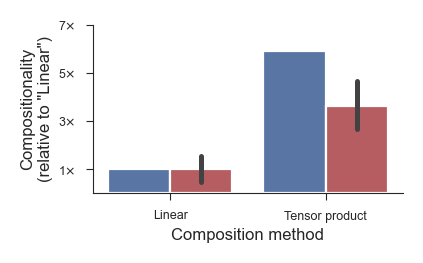

In [73]:
data = data_grammar_comp.copy()
data["Compositionality"] = data["Compositionality"] - 1
linear_comp = data[data["Composition method"] == "linear"][
    ["Compositionality", "Topological similarity"]
].mean()
data[["Compositionality", "Topological similarity"]] = (
    data[["Compositionality", "Topological similarity"]] / linear_comp
)
data = data.melt(
    id_vars=["Composition method"],
    value_vars=["Compositionality", "Topological similarity"],
    var_name="Metric",
    value_name="Value",
)
data["Composition method"] = data["Composition method"].map(
    {"linear": "Linear", "tensorproduct": "Tensor product"}
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 1.2))

sns.barplot(
    data=data,
    x="Composition method",
    y="Value",
    hue="Metric",
    hue_order=["Compositionality", "Topological similarity"],
    palette=[sns.color_palette()[0], sns.color_palette()[3]],
    ax=ax,
)

ax.set(ylabel='Compositionality\n(relative to "Linear")')
yticks = [1, 3, 5, 7]
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y}$\\times$" for y in yticks])
ax.legend().remove()

fig.savefig("saved/grammar_composition_method.pdf")
plt.show()

# Emergent languages

In [71]:
data_curve = get_run_results(
    entity="yoshua-bengio",
    project="Complexity - Prequential Coding - Emergent Languages",
    metrics=["K/K(interval i)"],
    x_axis="data encoded",
    filters={"config.z_num_attributes": 2, "config.z_num_vals": 8},
    save_path="data/emergent_languages_curve.csv",
)
data_results = get_run_results(
    entity="yoshua-bengio",
    project="Complexity - Prequential Coding - Emergent Languages",
    metrics=["K/K(Data)", "K/K(Data|f)", "K/K(f)"],
    filters={"config.z_num_attributes": 2, "config.z_num_vals": 8},
    save_path="data/emergent_languages_results.csv",
)
data_curve["reset"] = ~data_curve["data_dir"].str.contains("no-resets")
data_results["reset"] = ~data_results["data_dir"].str.contains("no-resets")

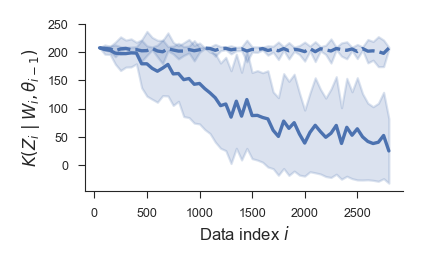

In [74]:
fig, ax = plt.subplots(figsize=(2, 1.2))

sns.lineplot(
    data=data_curve,
    x="data encoded",
    y="K/K(interval i)",
    style="reset",
    errorbar="sd",
    style_order=[True, False],
    color=sns.color_palette()[0],
    ax=ax,
)

ax.set(xlabel="Data index $i$", ylabel=r"$K(Z_i\; |\; W_i, \theta_{i-1})$")

ax.legend().remove()

fig.savefig("saved/emergent_languages_prequential_curve.pdf")
plt.show()